<h1>Capstone Project - The Battle of Neighborhoods. Vilnius

<h2>Introduction</h2>

Vilnius is a capitol of Lithuania. Is a very fast growing city. A new invester would like to open a new restaurant 
The objective of this project is to use Foursquare location data and regional clustering of venue information to determine what might be the ‘best’ neighborhood in Vilnius to open a restaurant.
Through this project, we will find the most suitable location for an entrepreneur to open a new restaurant in Vilnius, Lithuania.

Target Audience<br>
This project is aimed towards Entrepreneurs or Business owners who want to open a new Restaurant or grow their current business. The analysis will provide vital information that can be used by the target audience.

Data Overview<br>
The data that will be required will be a combination of CSV files that have been prepared for the purposes of the analysis from multiple sources which will provide the list of neighborhoods in Vilnius (https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius), the Geographical location of the neighborhoods (via Geocoder package) and Venue data pertaining to restaurants (via Foursquare). The Venue data will help find which neighborhood is best suitable to open an restaurant.


<h3>Business Problem</h3>

Important questions:<br>

1.Which Neighborhood is good for newcomer? <br>
2.Which type of Restaurants is popular and which not?

<h3>Methodology</h3>

    Business Understanding
The aim of this project is to find the best neighborhood of Vilnius to open a new restaurant.

    Analytical Approach
The total number of neighborhoods in Vilnius are 21 so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant.
Briefly, after some steps of Data Cleaning and Data Exploration, I will use a K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.

    Data Exploration
To explore the data, I will use “Folium” a python library that can create interactive leaflet map using coordinate data.

<h2>Data</h2>

1. Vilnius Neighborhoods via Wikipedia
https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius
2. Geographical Location taken from same page as above
https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius
3. Venue Data using Foursquare

let's transfer data from wikipedia to dataframe

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unicodedata import normalize

table_vln = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius')

In [14]:
print(f'Total tables: {len(table_vln)}')

Total tables: 3


In [15]:
table_vln = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius', match='Latitude')
len(table_vln)

1

In [16]:
df = table_vln[0]
df.head()

,Unnamed: 0,Neighborhoods,Area (km2)[1],Pop. (2001)[1],Density (2001)[1],Latitude,Longitude
0,1,Verkiai,56.0,30856,551.0,54.708707,25.284686
1,2,Antakalnis,77.2,39697,514.2,54.701126,25.308957
2,3,Pašilaičiai,7.9,25674,3249.9,54.725942,25.231328
3,4,Fabijoniškės,5.9,36644,6210.8,54.723397,25.249529
4,5,Pilaitė,13.9,15996,1150.8,54.708126,25.175803


In [17]:
df.shape

(21, 7)

In [18]:
vln=df.drop(['Area (km2)[1]','Pop. (2001)[1]','Density (2001)[1]','Unnamed: 0'], axis=1)

In [19]:
vln.head()

,Neighborhoods,Latitude,Longitude
0,Verkiai,54.708707,25.284686
1,Antakalnis,54.701126,25.308957
2,Pašilaičiai,54.725942,25.231328
3,Fabijoniškės,54.723397,25.249529
4,Pilaitė,54.708126,25.175803


In [20]:
 !pip install geocoder

In [21]:
!pip install folium

In [22]:
import geocoder # import geocoder

In [23]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [24]:
geolocator = Nominatim(user_agent="coursera")
address = 'Vilnius'
try:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))
except AttributeError:
    print('Cannot find: {}, will drop index: {}'.format(address, index))

my_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(vln['Latitude'], vln['Longitude'], vln['Neighborhoods']):
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(my_map)  
    
my_map

The geograpical coordinates of Vilnius are 54.6870458, 25.2829111.


In [25]:
# create map of Vilnius using latitude and longitude values
from folium import plugins
my_map = folium.Map(location=[latitude, longitude], zoom_start=11)

grouping = plugins.MarkerCluster().add_to(my_map)

# add markers to map
for lat, lng, label in zip(vln['Latitude'], vln['Longitude'], vln['Neighborhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(grouping)  
    
my_map

Foursquare API

In [26]:
# @hidden_cell
CLIENT_ID = '4MYN1GFRCK1DK03V0A2YNKT3YVUE1ZTEW52V1KDFCOUUITZS' # your Foursquare ID
CLIENT_SECRET = 'LYFIYCZSBFLJKENT2TPHPQLFTJWLDDPVKMJQVNF4ZOEJ0DPK' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [27]:
neighborhood_latitude = vln.loc[4]['Latitude']
neighborhood_longitude = vln.loc[4]['Longitude']

In [28]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
# @hidden_cell
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4MYN1GFRCK1DK03V0A2YNKT3YVUE1ZTEW52V1KDFCOUUITZS&client_secret=LYFIYCZSBFLJKENT2TPHPQLFTJWLDDPVKMJQVNF4ZOEJ0DPK&v=20180604&ll=54.708126,25.175803&radius=500&limit=100'

In [29]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '602e57b4051c9e661672b6d1'},
 'response': {'headerLocation': 'Pilaitė',
  'headerFullLocation': 'Pilaitė, Vilnius',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 54.7126260045, 'lng': 25.183577410535054},
   'sw': {'lat': 54.7036259955, 'lng': 25.168028589464942}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4daa3c7acda1652a2b892ae1',
       'name': 'JAMMI Kebabai',
       'location': {'address': 'Vydūno g. 15A',
        'lat': 54.70732785956105,
        'lng': 25.18017458460325,
        'labeledLatLngs': [{'label': 'display',
          'lat': 54.70732785956105,
          'lng': 25.18017458460325}],
        'distance': 294,
        'postalCode': '06206',
        'cc': 'LT',


In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [32]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,JAMMI Kebabai,Kebab Restaurant,54.707328,25.180175
1,Maxima X,Grocery Store,54.706827,25.176115
2,Pilaitės skatepark,Skate Park,54.707602,25.181061
3,Mažoji Ragainė,Bakery,54.707950,25.182445


In [33]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
# Run the above function on each location and create a new dataframe called location_venues and display it.
venues = getNearbyVenues(names=vln['Neighborhoods'],latitudes=vln['Latitude'],longitudes=vln['Longitude'])

Verkiai
Antakalnis
Pašilaičiai
Fabijoniškės
Pilaitė
Justiniškės
Viršuliškės
Šeškinė
Šnipiškės
Žirmūnai
Karoliniškės
Žvėrynas
Grigiškės
Lazdynai
Vilkpėdė
Naujamiestis
Senamiestis
Naujoji Vilnia
Paneriai
Naujininkai
Rasos


In [36]:
print(venues.shape)
venues.head()

(322, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Verkiai,54.708707,25.284686,Pizza Verde,54.707070,25.285050,Pizza Place
1,Verkiai,54.708707,25.284686,Močiutės Kepyklėlė,54.711061,25.286248,Bakery
2,Verkiai,54.708707,25.284686,Ulonų turgelis,54.709531,25.292245,Farmers Market
3,Verkiai,54.708707,25.284686,Alynas Beershop,54.709580,25.292089,Beer Store
4,Verkiai,54.708707,25.284686,Caffeine,54.709865,25.292171,Coffee Shop


In [37]:
# Let's check how many venues were returned for each neighborhood
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Antakalnis,15,15,15,15,15,15
Fabijoniškės,12,12,12,12,12,12
Grigiškės,1,1,1,1,1,1
Justiniškės,4,4,4,4,4,4
Karoliniškės,1,1,1,1,1,1
Lazdynai,6,6,6,6,6,6
Naujamiestis,30,30,30,30,30,30
Naujininkai,5,5,5,5,5,5
Naujoji Vilnia,5,5,5,5,5,5


In [38]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 114 uniques categories.


In [39]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

onehot.head()


,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tennis Court,Theater,Tree,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai


In [40]:
onehot.shape

(322, 115)

In [41]:
# let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,...,Tea Room,Tennis Court,Theater,Tree,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Antakalnis,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.066667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,Fabijoniškės,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.083333,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.083333,0.000000
2,Grigiškės,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,Justiniškės,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
4,Karoliniškės,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
5,Lazdynai,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
6,Naujamiestis,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.033333,0.0,0.033333,0.000000,0.033333,0.000000,0.00,0.033333,0.000000,0.000000
7,Naujininkai,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
8,Naujoji Vilnia,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
9,Paneriai,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000


In [42]:
grouped.shape

(21, 115)

In [43]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antakalnis----
                  venue  freq
0                  Park  0.20
1  Gym / Fitness Center  0.13
2                  Tree  0.07
3           Bus Station  0.07
4            Restaurant  0.07


----Fabijoniškės----
               venue  freq
0  Food & Drink Shop  0.17
1      Burrito Place  0.08
2          Wine Shop  0.08
3      Grocery Store  0.08
4        Pizza Place  0.08


----Grigiškės----
                      venue  freq
0                     River   1.0
1               Art Gallery   0.0
2  Mediterranean Restaurant   0.0
3                 Pet Store   0.0
4     Performing Arts Venue   0.0


----Justiniškės----
                venue  freq
0                 Gym  0.25
1         Flea Market  0.25
2              Market  0.25
3         Pizza Place  0.25
4  Mexican Restaurant  0.00


----Karoliniškės----
                   venue  freq
0                   Park   1.0
1            Art Gallery   0.0
2            Pizza Place   0.0
3              Pet Store   0.0
4  Performing Arts Venue

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Antakalnis,Park,Gym / Fitness Center,Gastropub,Restaurant,Gym
1,Fabijoniškės,Food & Drink Shop,Fast Food Restaurant,Electronics Store,Gas Station,Wine Shop
2,Grigiškės,River,Yoga Studio,Dessert Shop,Cheese Shop,Chinese Restaurant
3,Justiniškės,Pizza Place,Gym,Flea Market,Market,Dessert Shop
4,Karoliniškės,Park,Yoga Studio,Castle,Chinese Restaurant,Church
5,Lazdynai,Pizza Place,Grocery Store,Fast Food Restaurant,Pharmacy,Food Court
6,Naujamiestis,History Museum,Plaza,Cocktail Bar,Brewery,Burger Joint
7,Naujininkai,Grocery Store,Tennis Court,Convenience Store,Hotel,Yoga Studio
8,Naujoji Vilnia,Grocery Store,Platform,Italian Restaurant,Dance Studio,Bookstore
9,Paneriai,Castle,Yoga Studio,Chinese Restaurant,Church,Clothing Store


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets

grouped_clustering = grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(grouped_clustering)
    distortions.append(kmeanModel.inertia_)

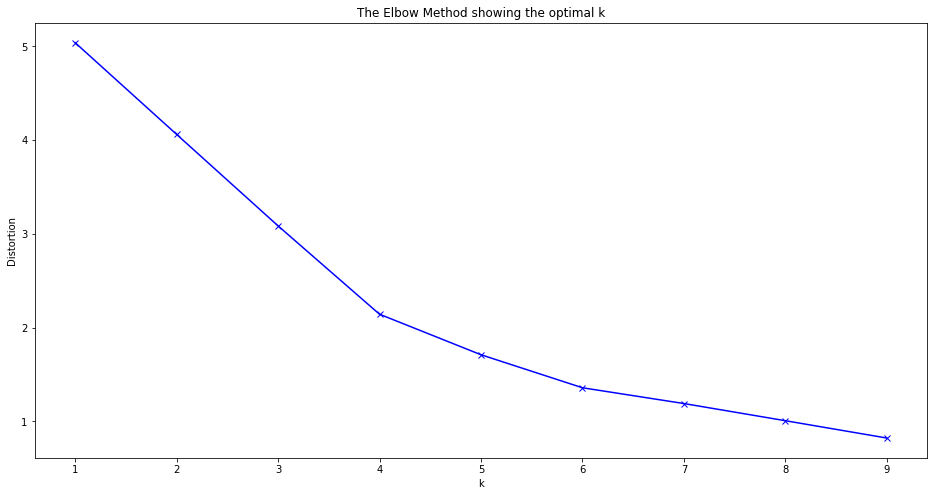

In [52]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

I use the "elbow" method to help select the optimal number of clusters by fitting the model with a range of values for k. The "elbow" (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

In [54]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 3, 1, 0, 0, 0, 0, 4], dtype=int32)

In [55]:
merged = grouped

# add clustering labels
merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

,Neighborhood,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Antakalnis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0,Park,Gym / Fitness Center,Gastropub,Restaurant,Gym
1,Fabijoniškės,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,...,0.0,0.0,0.083333,0.0,0,Food & Drink Shop,Fast Food Restaurant,Electronics Store,Gas Station,Wine Shop
2,Grigiškės,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,2,River,Yoga Studio,Dessert Shop,Cheese Shop,Chinese Restaurant
3,Justiniškės,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,3,Pizza Place,Gym,Flea Market,Market,Dessert Shop
4,Karoliniškės,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1,Park,Yoga Studio,Castle,Chinese Restaurant,Church


In [56]:
from sklearn import preprocessing, cluster
import scipy

In [57]:
vilnius_map = folium.Map(location=[54.6870458, 25.2829111], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vln['Latitude'], vln['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(vilnius_map)
       
vilnius_map

Cluster 0 - Red <br>
Cluster 1 - Purple <br>
Cluster 2 - light blue<br>
Cluster 3 - cyan<br>
Cluster 4 - orange<br>

In [58]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5,merged.shape[1]))]]

,Art Gallery,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0,Park,Gym / Fitness Center,Gastropub,Restaurant,Gym
1,0.000000,0.000000,0.000000,0.000000,0.083333,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.083333,0.000000,0,Food & Drink Shop,Fast Food Restaurant,Electronics Store,Gas Station,Wine Shop
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0,Pizza Place,Grocery Store,Fast Food Restaurant,Pharmacy,Food Court
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.033333,0.000000,0.000000,0,History Museum,Plaza,Cocktail Bar,Brewery,Burger Joint
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0,Grocery Store,Tennis Court,Convenience Store,Hotel,Yoga Studio
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0,Grocery Store,Platform,Italian Restaurant,Dance Studio,Bookstore
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.090909,...,0.00,0.000000,0.000000,0.000000,0,Gym / Fitness Center,Kebab Restaurant,Pet Store,Food,Pizza Place
11,0.000000,0.000000,0.250000,0.000000,0.000000,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0,Kebab Restaurant,Grocery Store,Bakery,Skate Park,Diner
12,0.000000,0.000000,0.020000,0.050000,0.020000,0.05,0.01,0.0000,0.010000,0.010000,...,0.01,0.030000,0.000000,0.010000,0,Hotel,Coffee Shop,Restaurant,Bar,Beer Bar
13,0.000000,0.031250,0.000000,0.000000,0.031250,0.00,0.00,0.0000,0.000000,0.000000,...,0.00,0.031250,0.000000,0.000000,0,History Museum,Plaza,Brewery,Cocktail Bar,Bus Stop


In [59]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5,merged.shape[1]))]]

,Art Gallery,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,Park,Yoga Studio,Castle,Chinese Restaurant,Church


In [60]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[1] + list(range(5,merged.shape[1]))]]

,Art Gallery,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,River,Yoga Studio,Dessert Shop,Cheese Shop,Chinese Restaurant


In [61]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[1] + list(range(5,merged.shape[1]))]]

,Art Gallery,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,Pizza Place,Gym,Flea Market,Market,Dessert Shop
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,Pizza Place,Gym,Flea Market,Market,Dessert Shop


In [62]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5,merged.shape[1]))]]

,Art Gallery,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,...,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4,Castle,Yoga Studio,Chinese Restaurant,Church,Clothing Store


Here we are at the end of the analysis, I tried to set up a realistic data-analysis scenario using Vilnius data on Wikipedia. I have used some powerful python libraries eg. Folium and GeoPandas, Foursquare API, etc…
So now we have the opportunity to make some argument about the clusters. Let’s see what we have found:<br>
1.The most common venue in Cluster 3 is Pizza Place. <br>
2.In Clusters 1,2 and 4 we can find only a Chinese Restaurant. So there could be a good place to other tipe of Restaurant.<br>
3.Newcomer should avoid Cluster 0, because there is a lot of different tipes of Restaurants.

In [65]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


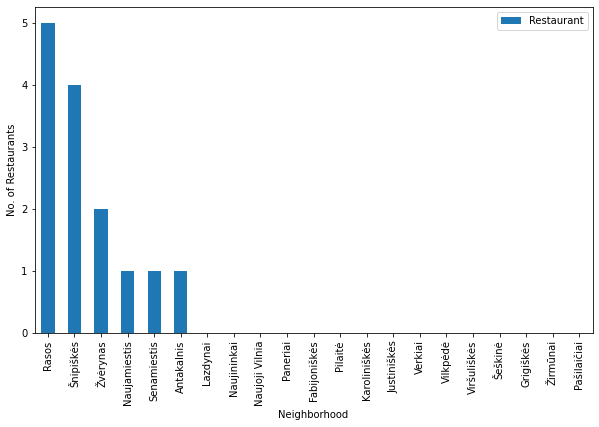

In [66]:
graph = pd.DataFrame(onehot.groupby('Neighborhood')['Restaurant'].sum())
graph = graph.sort_values(by='Restaurant', ascending=False)
graph.iloc[:].plot(kind='bar',figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('No. of Restaurants')
plt.show()

There is a non-specialized restaurant in only 6 districts

In [67]:
onehot.head()

,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,...,Tennis Court,Theater,Tree,Vegetarian / Vegan Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Verkiai


In [68]:
onlyrestaurants = onehot[["Vegetarian / Vegan Restaurant" , "Asian Restaurant" , "Belgian Restaurant" , "Chinese Restaurant" , "Eastern European Restaurant" , "Falafel Restaurant" , "Fast Food Restaurant" , "French Restaurant" , "Italian Restaurant" , "Kebab Restaurant" , "Mediterranean Restaurant" , "Middle Eastern Restaurant" , "Modern European Restaurant" , "Restaurant" , "Seafood Restaurant" , "Sushi Restaurant"]]  

In [69]:
onlyrestaurants

,Vegetarian / Vegan Restaurant,Asian Restaurant,Belgian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
318,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


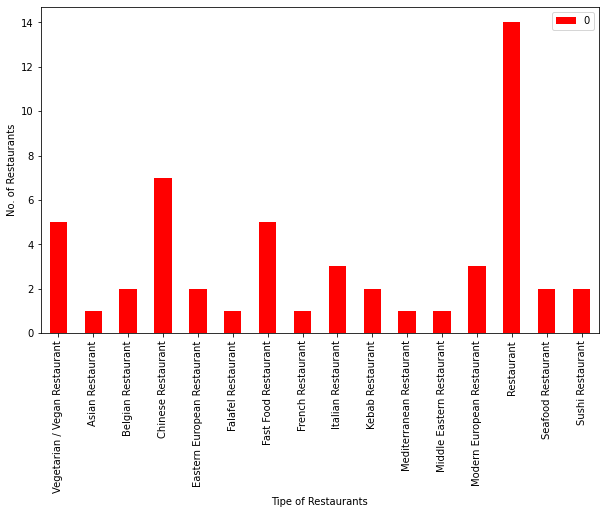

In [70]:
graph = pd.DataFrame(onlyrestaurants.sum())
graph.iloc[:].plot(kind='bar',figsize=(10,6),color='red')
plt.xlabel('Tipe of Restaurants')
plt.ylabel('No. of Restaurants')
plt.show()

We can clearly see that specialty restaurants are not very popular.

In [71]:
specific = onehot[["Vegetarian / Vegan Restaurant" , "Asian Restaurant" , "Belgian Restaurant" , "Chinese Restaurant" , "Eastern European Restaurant" , "Falafel Restaurant" , "Fast Food Restaurant" , "French Restaurant" , "Italian Restaurant" , "Kebab Restaurant" , "Mediterranean Restaurant" , "Middle Eastern Restaurant" , "Modern European Restaurant" , "Seafood Restaurant" , "Sushi Restaurant"]]  

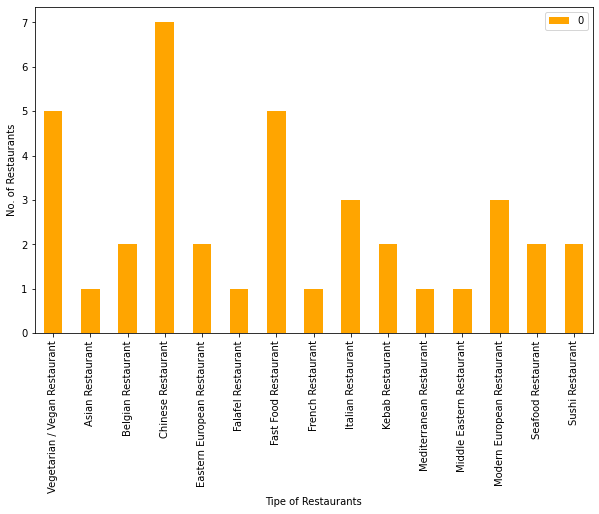

In [72]:
graph = pd.DataFrame(specific.sum())
graph.iloc[:].plot(kind='bar',figsize=(10,6),color='orange')
plt.xlabel('Tipe of Restaurants')
plt.ylabel('No. of Restaurants')
plt.show()

If we planning opening a new Restaurant, we should not focus on Vegetarian, Chinese and Fast Food Restaurant. These types of Restaurant dominance in this city. 

In [73]:
restaurantNeighborhood = onehot[["Vegetarian / Vegan Restaurant" , "Asian Restaurant" , "Belgian Restaurant" , "Chinese Restaurant" , "Eastern European Restaurant" , "Falafel Restaurant" , "Fast Food Restaurant" , "French Restaurant" , "Italian Restaurant" , "Kebab Restaurant" , "Mediterranean Restaurant" , "Middle Eastern Restaurant" , "Modern European Restaurant" , "Restaurant" , "Seafood Restaurant" , "Sushi Restaurant", "Neighborhood"]]  

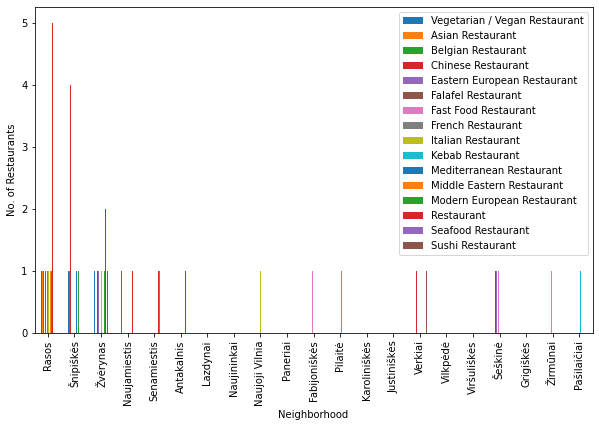

In [74]:
graph = pd.DataFrame(restaurantNeighborhood.groupby('Neighborhood').sum())
graph = graph.sort_values(by='Restaurant', ascending=False)
graph.iloc[:].plot(kind='bar',figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('No. of Restaurants')
plt.show()

Neighborhood of Rasos, Šnipiškės and Žvėrynas are leaders comparing with other districts. If newcommer want to dominate in Neighborhood, he should focus on Lazdynai, Naujininkai, Pilaitė, Paneriai, Grigiškės, Karoliniškės, Vilkpėdė, Viršuliškės and Justiniškės.

In [75]:
restaurantNeighborhood.groupby('Neighborhood').sum()

,Vegetarian / Vegan Restaurant,Asian Restaurant,Belgian Restaurant,Chinese Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant
Neighborhood,,,,,,,,,,,,,,,,
Antakalnis,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Fabijoniškės,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Grigiškės,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Justiniškės,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Karoliniškės,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lazdynai,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Naujamiestis,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
Naujininkai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Naujoji Vilnia,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


<h1>Results</h1>

Based on the Data Analysis and Visualization using Cluster, Folium and Matplotlib we have rendered various bar charts and map from which we can come to a better understanding of the interests we had earlier to be discovered which are specified as follows.<br>
From Clustering we can clearly state:<br>
1. The most common venue in Cluster 3 is Pizza Place.<br>
2. In Clusters 1,2 and 4 we can find only a Chinese Restaurant. So there could be a good place to other tipe of Restaurant.<br>
3. Newcomer should avoid Cluster 0, because there is a lot of different tipes of Restaurants.<br>

Bar charts help us to understand:
1. Specialty restaurants are not very popular in Vilnius.
2. If we planning opening a new Restaurant, we should not focus on Vegetarian, Chinese and Fast Food Restaurant. These types of Restaurant dominance in this city.
3. Neighborhood of Rasos, Šnipiškės and Žvėrynas are leaders comparing with other districts in Restaurant section.



<h1>Discussion</h1>

We could improve our results and conclusions if we knew whether the stakeholder was looking for a place more in the suburbs (where there is less competition) or whether he would look for a place more in the center (more traffic).
For better results we could use the population of each district. 

<h1>Conclusion </h1>

In conclusion, to end off this project, we had an opportunity on a business problem, and it was tackled in a way that it was similar to how a genuine data scientist would do. We utilized numerous Python libraries to fetch the information, control the content and break down and visualize those datasets. We have utilized Foursquare API to investigate the settings in neighbourhoods of Vilnius. We also visualized utilizing different plots present in seaborn and Matplotlib libraries. We have used Folium to picture different neighborhoods on a map.<br>
In general, it could be one of the tools in developing your business. Whether you want to open a restaurant, a hairdresser, a movie theater, a gym or something else.
